### Compare theoretical and ground state energy at unit filling

In [388]:
import numpy as np
import matplotlib.pyplot as plt
import pimc
import importlib

### Simulation parameters

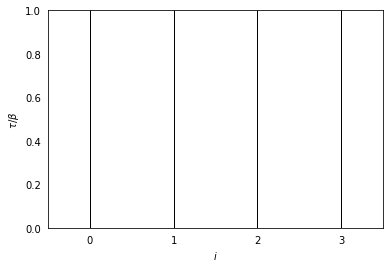

In [499]:
# Simulation parameters
N = 4
L = N   # unit-filling
t = 0
U = 0.5
mu = -0.1
canonical = True # False for Grand Canonical simulation
    
# PIMC parameters
beta = 1
#eta = 1/np.sqrt(L*beta)      # worm end fugacity
eta = (7/2)*U
eta = 1

# Create unit filling initial configuration
alpha = []
for i in range(L):
    alpha.append(1)
alpha

data_struct = pimc.create_data_struct(alpha)
head_loc = []
tail_loc = []
pimc.view_worldlines(data_struct,beta,figure_name=None)

### Do many iterations of the set of PIMC-WA updates

In [522]:
importlib.reload(pimc)
# Do insert many times on the above configuration
data_struct = pimc.create_data_struct(alpha)
head_loc = []
tail_loc = []
mc_steps = int(1E+05)
samples = 0
egs = 0
for m in range(mc_steps):
    
    pimc.worm_insert(data_struct,beta,head_loc,tail_loc,U,mu,eta,canonical,N)      
    pimc.worm_delete(data_struct,beta,head_loc,tail_loc,U,mu,eta,canonical,N)
    pimc.worm_timeshift(data_struct,beta,head_loc,tail_loc, U, mu,canonical,N)
    pimc.insert_gsworm_zero(data_struct,beta,head_loc,tail_loc,U,mu,eta,canonical,N)
    pimc.delete_gsworm_zero(data_struct, beta, head_loc, tail_loc,U,mu,eta,canonical,N)
    #pimc.insert_gsworm_beta(data_struct,beta,head_loc,tail_loc,U,mu,eta,canonical,N)        
    #pimc.delete_gsworm_beta(data_struct, beta, head_loc, tail_loc,U,mu,eta,canonical,N)
         
    if pimc.egs_pimc(data_struct,beta,U,mu) < 0:
        print("This bad boy is negative")
        
    # Calculate diagonal energy when there are no worms present
    if m >= 0.2*mc_steps and m%L==0: # Ignore unequilibrated data
        if head_loc == [] and tail_loc == []:
            samples += 1
            egs += pimc.egs_pimc(data_struct,beta,U,mu)

In [523]:
# Average ground state energy
egs /= samples

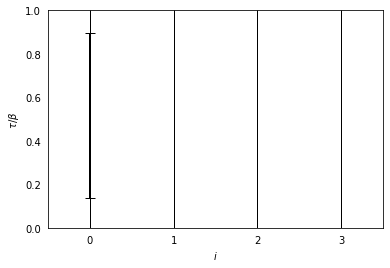

N_check:  4.757763793749408


In [524]:
pimc.view_worldlines(data_struct,beta,figure_name=None)
print("N_check: ",pimc.N_tracker(data_struct,beta))

In [525]:
print("-------- Ground State Energy --------")
#print("PIMC: %.8f"%(egs/N_egs))
print("Samples: %d"%samples)
print("Exact: %.8f"%egs_theory(L,U,mu))
print("PIMC: %.8f"%egs)

-------- Ground State Energy --------
Samples: 69
Exact: -0.09000000
PIMC: 0.40000000
